# Lista 10
Część pierwsza sprawozdania.

In [1]:
# HIDE!

#install.packages("kableExtra")
#install.packages("tidyverse")
#install.packages("exact2x2")
#install.packages("patchwork")


library(tidyverse)
library(knitr)
library(kableExtra)
library(IRdisplay)
library(gnm)
library(dplyr)
library(exact2x2)
library(ggplot2)
library(patchwork)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: 'kableExtra'


The following object is masked from 'package:dplyr':

    group_rows


Loading required package: exactci

Loading required package: ssanv

Loading required package: testthat


Attaching package: 'testthat'


The following object is masked from 'package:dplyr':

    matches


The following object is masked from 'package:purrr':

    is_null


The following objects are masked from 'package:readr':

    edition_get, local_edition


The following object is masked from 'package:tidyr':

    matches




## Zadanie 1

Aby zweryfikować hipotezę, że studenci byli tak samo przygotowani do obu kolokwiów, musimy zweryfikować hipotezę o jednorodności rozkładów brzegowych. 

In [2]:
mcnemara_test <- function(data, correct = F) {
  if (correct) {
    Z0 <- (abs(data[1,2] - data[2,1]) - 1)^2 / (data[1, 2] + data[2, 1])
    2*(1-pnorm(sqrt(abs(Z0))))
  } else {
    Z0 <- (data[1,2] - data[2,1])/(sqrt(data[1,2] + data[2,1]))
    2*(1-pnorm(abs(Z0)))
  }
}

In [3]:
data <- matrix(c(32, 22, 44, 38), nrow = 2)
data


32,44
22,38


Następnie przeprowadzimy test za pomocą zaimplementowanej przez nas funkcji oraz wbudowanej w pakiet R.

In [4]:
mcnemara_test(data)
mcnemar.test(data, correct = F)$p.value

[1] 0.006768741

[1] 0.006768741

Obie funkcje zwracją ten sam wynik, zatem test został poprawnie zaimplementowany.

### Wnioski
Wartość poziomu krytycznego w teście McNemary wynosi $0.0068$, zatem jest mniejsza niż przyjęty przez nas poziom istotności $\alpha = 0.05$. Zatem odrzucamy hipotezę zerową, a wyniku tego możemy stwierdzić, że studenci nie byli przygotowani tak samo do obu kolokwiów.

## Zadanie 2

Oznaczmy zmienne losowe: 
- $A$ - rekacja na lek A, 
- $B$ - reakcja na lek B.

Hipoteza, że leki są jednakowo skuteczne jest równoważna hipotezie, że zmienna losowa $A$ i zmienna losowa $B$ są jednakowe. Zatem wykonamy test McNemary, w której hipoteza zerowa ma postać:
$$H_0: p_{1+} = p_{+1}$$

Natomiast hipteza alternatywna:
$$H_1: p_{1+} \neq p_{+1}$$

In [5]:
data <- matrix(c(1, 2, 5, 4), nrow=2)
data

1,5
2,4


Test McNemary z korektą na ciągłość:

In [6]:
mcnemara_test(data, correct = T)
mcnemar.test(data, correct = T)$p.value

[1] 0.4496918

[1] 0.4496918

Oba testy zwróciły tą samą wartość, zatem test McNemary z korektą na ciągłość został zaimplentowany poprawnie.

### Wnioski
Wartość krytyczna testu wynosi $\approx 0.45$, zatem przyjmując poziom istotności $\alpha = 0.05$ nie mamy podstaw do odrzucenia hipotezy zerowej. 

### Test dokładny

In [7]:
exact_test <- function(data) {
  if (data[1,2] == (data[1,2] + data[2,1]) / 2) {
    1
  } else if (data[1,2] < (data[1,2] + data[2,1]) / 2) {
    sum_res <- 0
    for ( k in 0:data[1,2]) {
      sum_res <- sum_res + choose(data[1,2] + data[2,1], k) * (0.5)^k * ((0.5)^(data[1,2] + data[2,1] - k))
    }
    2 * sum_res
  } else {
    sum_res <- 0
    end <- data[1,2] + data[2,1]
    for ( k in data[1,2]:end) {
      #print(k)
      #print(choose(data[1,2] + data[2,1], k))
      sum_res <- sum_res + choose(data[1,2] + data[2,1], k) * (0.5)^k * ((0.5)^(data[1,2] + data[2,1] - k))
    }
    2* sum_res
  }
}

Wykonamy test za pomocą wbudowanej funckji oraz zaimplementowanej przez nas:

In [8]:
exact_test(data)
mcnemar.exact(data)$p.value

[1] 0.453125

[1] 0.453125

W tym przypadku również oba wyniki są identyczne.

### Wnioski
Dokładny test również zwraca dużą wartość krytyczną, która wynosi $\approx 0.453$, zatem nie mamy podstaw do odrzucenia hipotezy zerowej.

## Zadanie 3

Zaimplementujmy test $Z$.

In [9]:
z_test <- function(data) {
  n <- sum(data)
  p_plus1 <- sum(data[, 1])/n
  p_1plus <- sum(data[1, ])/n

    
  p_11 <- data[1,1] / n
  p_12 <- data[1,2] / n
  p_21 <- data[2,1] / n
  p_22 <- data[2,2] / n
    
    

  
  D <- p_1plus - p_plus1
#     print("DSS")
#     print(D)
  sigma2 <- (p_1plus * (1 - p_1plus) + p_plus1 * (1 - p_plus1) + 2 * (p_11 * p_22 - p_12 * p_21)) / n
#     print(sigma2)
  z <- (D / sqrt(sigma2))
    
    2*(1-pnorm(abs(z)))
}

z0_test <- function(data) {
    z0 <- (data[1,2] - data[2,1])/(sqrt(data[1,2] + data[2,1]))
    2*(1-pnorm(abs(z0)))
}

#### Sprawdzenie poprawności implementacji testów $Z$ i $Z_0$. 
W tym celu wygenrujemy dane z odpowiednimi prawdopodobieństwami $p_1, p_2$.

In [10]:
test_impl <- function(n, p1, p2) {
    X_1 <- sum(runif(n) < p1)
    X_0 <- n-X_1
    Y_1 <- sum(runif(n) < p2)
    Y_0 <- n - Y_1
    data <- matrix(c(X_0, X_1 , Y_1, Y_0), nrow=2, byrow = T)
    print(sprintf("p1 = %f, p2 = %f", p1, p2))
    print(sprintf("Test Z - p-value = %f", z_test(data)))
    print(sprintf("Test Z_0 - p-value = %f", z0_test(data)))
}

In [11]:
test_impl(1000, 0.5, 0.5)

[1] "p1 = 0.500000, p2 = 0.500000"
[1] "Test Z - p-value = 1.000000"
[1] "Test Z_0 - p-value = 1.000000"


Kiedy przyjmujemy prawdopodobieństwa $p_1 = p_2$, p-wartość w obu testach jest znacznie powyżej poziomu istotności $\alpha = 0.05$, zatem zgodnie z naszymi oczekiwaniami test odrzuca hipotezę o jednorodności rozkładów.

In [12]:
test_impl(1000, 0.6, 0.5)

[1] "p1 = 0.600000, p2 = 0.500000"
[1] "Test Z - p-value = 0.005399"
[1] "Test Z_0 - p-value = 0.009132"


In [13]:
test_impl(1000, 0.4, 0.5)

[1] "p1 = 0.400000, p2 = 0.500000"
[1] "Test Z - p-value = 0.000075"
[1] "Test Z_0 - p-value = 0.000012"


Natomiast kiedy weźmiemy $p_1 \neq p_2$, oba testy zwracją bardzo niską p-wartość, na podstawie której możemy odrzucić hipotezę zerową mówiącą o jednorodności rozkładów. Zatem oba testy zostały zaimplementowane poprawnie.

In [14]:
generate_data <- function(n, p1, p2) {
    X_1 <- sum(runif(n) < p1)
    X_0 <- n-X_1
    Y_1 <- sum(runif(n) < p2)
    Y_0 <- n - Y_1
    matrix(c(X_0, X_1 , Y_1, Y_0), nrow=2, byrow = T)
}
test_power <- function(n, M, alpha ) {
    
    p1 <- 0.5
    p2s <- seq(0.01, 0.99, by=0.01)
    z_result <- numeric(length(p2s))
    z0_result <- numeric(length(p2s))
    for (i in 1:length(p2s)) {
        p2 = p2s[i]
        rejected_z <- 0
        rejected_z0 <- 0
        for (y in 1:M) {
            data <- generate_data(n, p1, p2)
            
            z_res <- if(z_test(data) < alpha) 1 else 0;
            rejected_z <- rejected_z + z_res

            z0_res <- if(z0_test(data) < alpha) 1 else 0;
            rejected_z0 <- rejected_z0 + z0_res
        }
        z_result[i] <- rejected_z
        z0_result[i] <- rejected_z0
    }
    
    df1 <- data.frame(x=p2s, y=z_result/M)
    df2 <- data.frame(x=p2s, y=z0_result/M)
    
    q1 <- ggplot(df1) + geom_line(aes(x, y)) +
    ggtitle("Moc testu Z") +
  xlab("p_2") + ylab("moc")
    q2 <- ggplot(df2) + geom_line(aes(x, y)) +
    ggtitle("Moc testu Z0") +
  xlab("p_2") + ylab("moc")
    
    q1 / q2
    
    
}

Sprawdźmy jak wyglądają wykresy mocy poszczególnych testów dla n = $(20, 30, 50, 100, 1000)$
 - $M = 1000$
 - $\alpha = 0.05$
 
 
 W pierwszej kolejności wygenerujemy wykres dla $n=20$

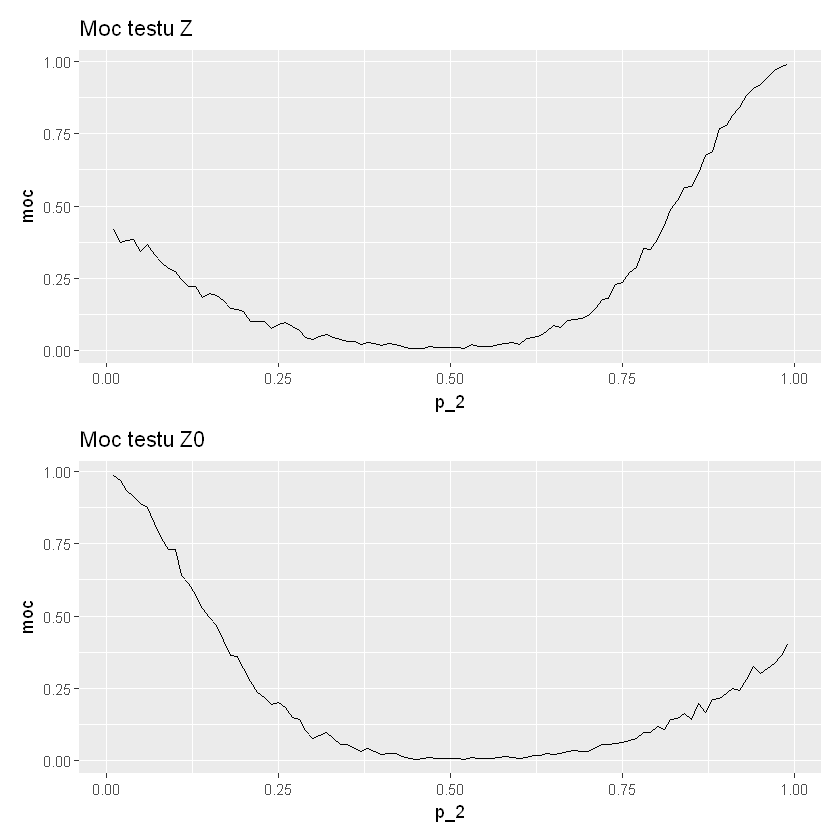

In [15]:
test_power(20, 1000, 0.05)

$n = 30$

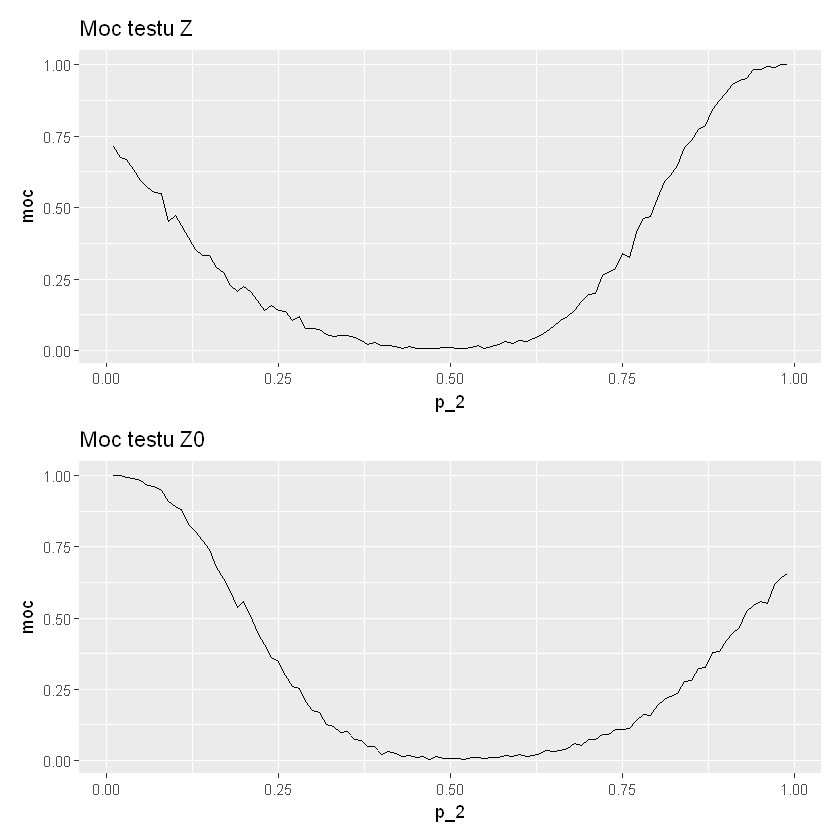

In [16]:
test_power(30, 1000, 0.05)

$n = 50$

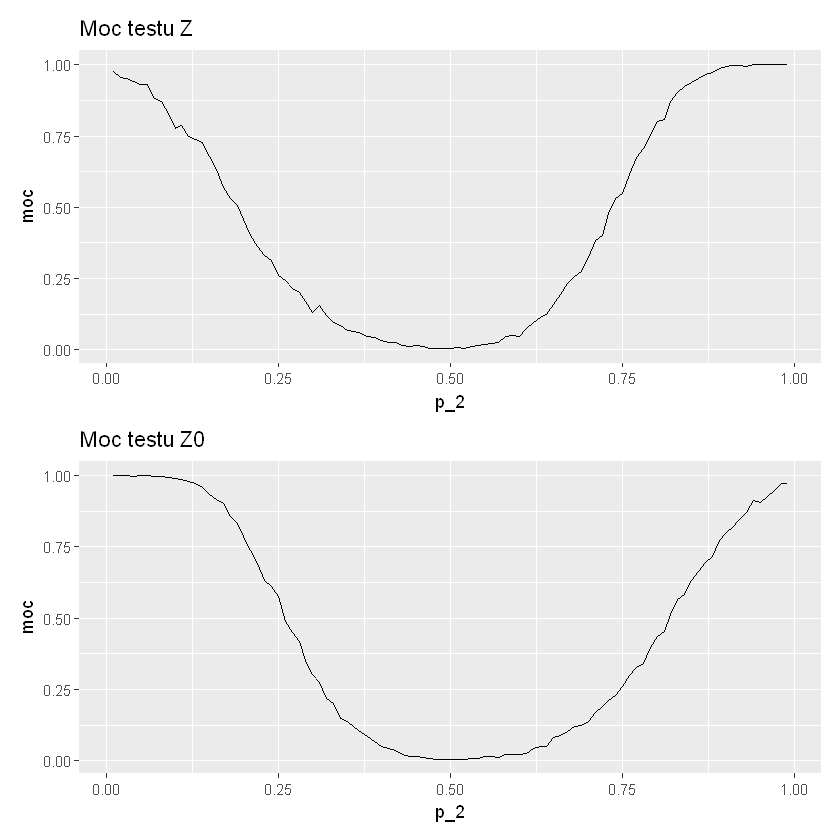

In [17]:
test_power(50, 1000, 0.05)

$n = 100$

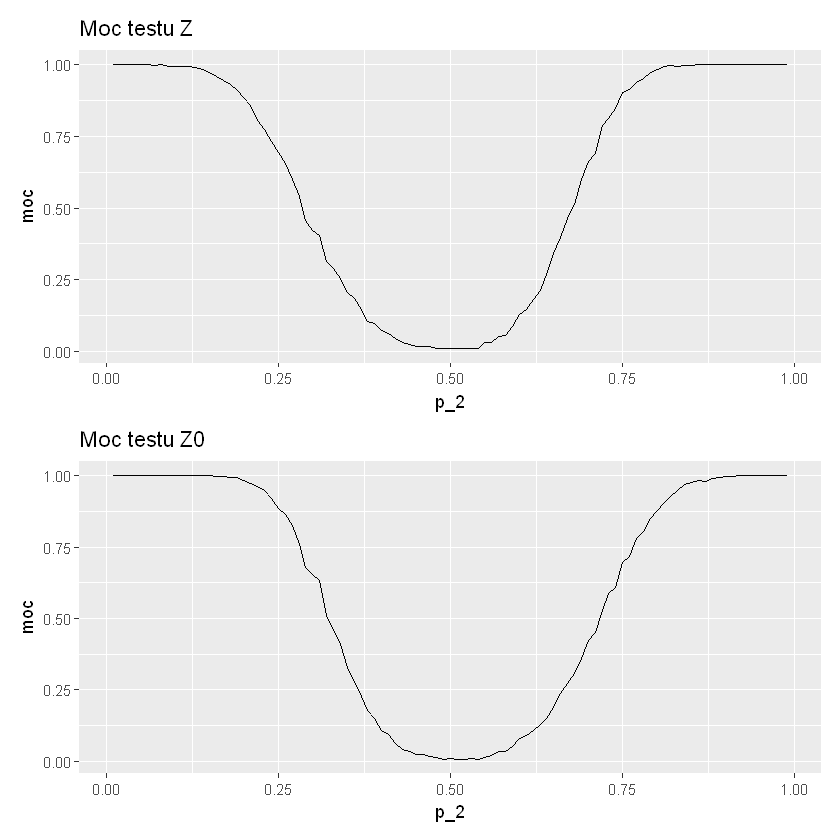

In [18]:
test_power(100, 1000, 0.05)

$n = 1000$

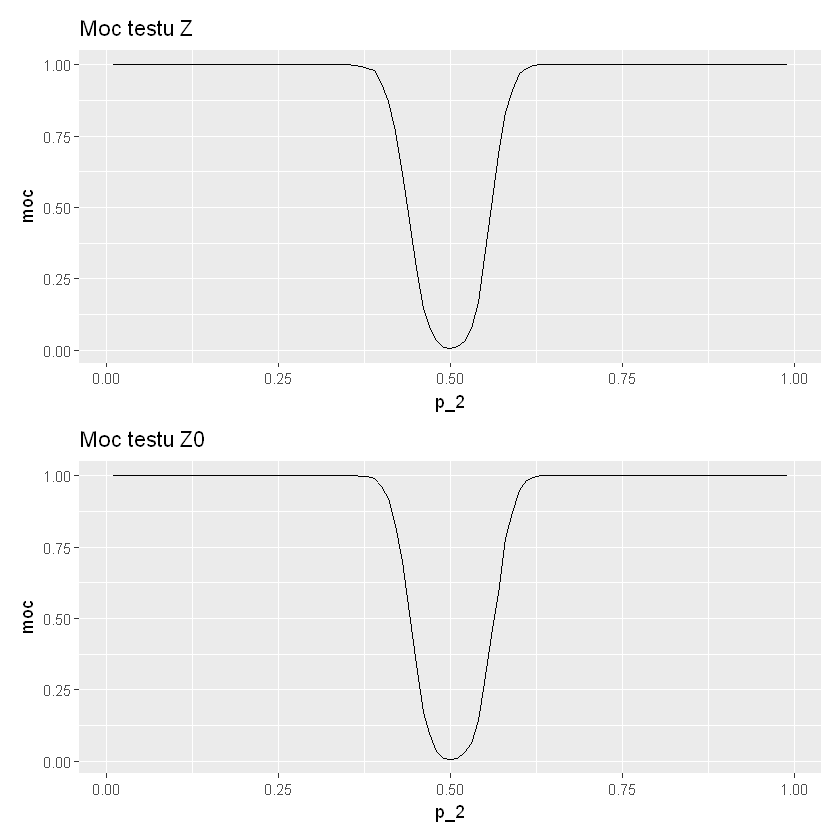

In [19]:
test_power(1000, 1000, 0.05)

# Lista 11
Część druga sprawozdania.

## Zadanie 1

W zadaniu pierwszym przeprowadzimy test symetrii, quasi-symetrii i quasi-niezależności dla danych dotyczących ocen uzyskanych przez studentów z dwóch kolokwiów. Wszystkie testy zostaną przeprowadzone na poziomie istotności $0.05$.

In [20]:
# HIDE INPUT

count <- c(5, 2, 1, 0, 0, 0,
           6, 3, 2, 2, 0, 0,
           1, 4, 5, 5, 2, 2,
           0, 10, 15, 18, 5, 2,
           1, 2, 5, 3, 2, 2,
           0, 1, 3, 4, 3, 2)

data <- matrix(count, byrow=TRUE, nrow=6)
rownames(data) = c("2", "3", "+3", "4", "+4", "5")
colnames(data) = c("2", "3", "+3", "4", "+4", "5")

data

,2,3,+3,4,+4,5
2,5,2,1,0,0,0
3,6,3,2,2,0,0
+3,1,4,5,5,2,2
4,0,10,15,18,5,2
+4,1,2,5,3,2,2
5,0,1,3,4,3,2


### Symetria
Przy testowaniu symetrii, moglibyśmy skorzystać z testu Bowkera, jednak w przypadku naszych danych nie jest to możliwe. Wywołanie tego testu (`mcnemar.test`) zwróciłoby p-wartość `NaN`. Dlatego należy skorzystać z testu ilorazu wiarygodności, zaimplementowanego w funkcji `glm` biblioteki `gnm`.

In [21]:
count <- c(5, 2, 1, 0, 0, 0,
           6, 3, 2, 2, 0, 0,
           1, 4, 5, 5, 2, 2,
           0, 10, 15, 18, 5, 2,
           1, 2, 5, 3, 2, 2,
           0, 1, 3, 4, 3, 2)

K1 <- gl(6,6, labels=c("2", "3", "+3", "4", "+4", "5"))
K2 <- gl(6,1, labels=c("2", "3", "+3", "4", "+4", "5"))
data <- data.frame(K1, K2, count)

symmetry <- glm(count ~ Symm(K1, K2), data=data, family=poisson)
symmetry %>% summary()


Call:
glm(formula = count ~ Symm(K1, K2), family = poisson, data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8988  -0.5463   0.0000   0.4981   1.4888  

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)        1.609e+00  4.472e-01   3.599  0.00032 ***
Symm(K1, K2)2:3   -2.231e-01  5.701e-01  -0.391  0.69549    
Symm(K1, K2)2:+3  -1.609e+00  8.367e-01  -1.924  0.05440 .  
Symm(K1, K2)2:4   -1.991e+01  4.043e+03  -0.005  0.99607    
Symm(K1, K2)2:+4  -2.303e+00  1.095e+00  -2.102  0.03556 *  
Symm(K1, K2)2:5   -1.991e+01  4.043e+03  -0.005  0.99607    
Symm(K1, K2)3:3   -5.108e-01  7.303e-01  -0.699  0.48425    
Symm(K1, K2)3:+3  -5.108e-01  6.055e-01  -0.844  0.39889    
Symm(K1, K2)3:4    1.823e-01  5.323e-01   0.343  0.73196    
Symm(K1, K2)3:+4  -1.609e+00  8.367e-01  -1.924  0.05440 .  
Symm(K1, K2)3:5   -2.303e+00  1.095e+00  -2.102  0.03556 *  
Symm(K1, K2)+3:+3  2.561e-15  6.325e-01   0.000  1.00000    
Symm

Policzmy zatem p-wartość.

In [22]:
x = symmetry$deviance
r = 15

p = 1 - pchisq(x, r)
p %>% round(4)

[1] 0.1005

Otrzymujemy p-wartość na poziomie $0.1005 > 0.05$, więc nie mamy podstaw do odrzucenia hipotezy o niezależności.

### Quasi-symetria
Ponownie skorzystamy z funkcji `glm`.

In [23]:
quasi_symm <- glm(count ~ K1+K2 + Symm(K1,K2), data=data, family =poisson)
summary(quasi_symm)


Call:
glm(formula = count ~ K1 + K2 + Symm(K1, K2), family = poisson, 
    data = data)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-0.86903  -0.08908   0.00000   0.06047   0.80881  

Coefficients: (5 not defined because of singularities)
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)          1.60944    0.44721   3.599  0.00032 ***
K13                 -1.83252    1.17661  -1.557  0.11936    
K1+3                 0.29184    0.76722   0.380  0.70365    
K14                  1.16686    0.72161   1.617  0.10587    
K1+4                 0.86552    0.77135   1.122  0.26183    
K15                  0.85966    0.63615   1.351  0.17658    
K23                 -2.61466    1.16128  -2.252  0.02435 *  
K2+3                -1.11675    0.74555  -1.498  0.13416    
K24                 -1.28102    0.71818  -1.784  0.07447 .  
K2+4                -1.37441    0.75441  -1.822  0.06848 .  
K25                 -1.77595    0.63615  -2.792  0.00524 ** 

In [24]:
x = quasi_symm$deviance
r = 10
p = 1 - pchisq(x, r)

p %>% round(4)

[1] 0.9589

Otrzymana p-wartość na poziomie $0.9589$ nie daje podstaw do odrzucenia hipotezy o quasi-symetrii.

### Quasi-niezależność
Do testowania quasi-niezależności również możemy wykorzystać funkcję `glm`.

In [25]:
quasi_ind <-  glm(count ~ K1 + K2 + Diag(K1, K2), data=data, family = poisson)
summary(quasi_ind)


Call:
glm(formula = count ~ K1 + K2 + Diag(K1, K2), family = poisson, 
    data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5605  -0.6443  -0.0649   0.2053   3.3845  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -1.3500     0.6876  -1.963 0.049590 *  
K13              1.3547     0.6616   2.048 0.040602 *  
K1+3             1.8306     0.6423   2.850 0.004372 ** 
K14              2.5373     0.6092   4.165 3.12e-05 ***
K1+4             1.5024     0.6425   2.338 0.019370 *  
K15              1.2838     0.6527   1.967 0.049190 *  
K23              0.9628     0.4241   2.270 0.023181 *  
K2+3             1.3646     0.4095   3.333 0.000861 ***
K24              1.0334     0.4545   2.274 0.022994 *  
K2+4             0.3432     0.4768   0.720 0.471570    
K25             -0.1993     0.5417  -0.368 0.712931    
Diag(K1, K2)2    2.9595     0.8202   3.608 0.000308 ***
Diag(K1, K2)3    0.1312     0.7110   0.184 0.853635   

In [26]:
x = quasi_ind$deviance
r = 19
p = 1 - pchisq(x, r)
p %>% round(4)

[1] 0.0096

Test ilorazu wiarygodności zwraca p-wartość $0.0096 < 0.05$, więc odrzucamy hipotezę zerową o quasi-niezależności.

## Zadanie 2

W zadaniu drugim musimy wskazać, że rozkłady brzegowe są jednorodne. W poprzednim popdunkcie nie odrzuciliśmy hipotezy o quasi-symetrii, więc wnioskujemy że ona zachodzi. W takim przypadku, testowanie brzegowej jednorodności sprowadza się do testowania symetrii, pod warunkiem, że zachodzi quasi-symetria. 

Tę hipotezę można zweryfikować za pomocą testu IW, który w pakiecie R zaimplementowany jest w funkcji `anova`.

In [27]:
comparison <- anova(symmetry, quasi_symm)
comparison

,Resid. Df,Resid. Dev,Df,Deviance
,<dbl>,<dbl>,<dbl>,<dbl>
1,15,22.28825,NA,NA
2,10,3.72455,5,18.5637


Obliczmy zatem p-wartość.

In [28]:
p = 1-pchisq(18.5637,5)
p %>% round(4)

[1] 0.0023

Korzystając z testu IW, dla $\alpha = 0.05$, odrzucamy hipotezę o symetrii, pod warunkiem, że zachodzi quasi-symetria (p-wartość jest równa $0.0023$). Zatem należy również odrzucić hipotezę o jednorodności rozkładów brzegowych.

# Lista 12, 13, 14

Część trzecia sprawozdania.

## Zadanie 1

W zadaniu pierwszym naszym zadaniem jest interpretacja modeli log-liniowych hierarchicznie uporządkowanych. Dane w zadaniach 1-4 pochodzą z pliku `Ankieta.csv`, zawierającego wyniki ankietowania 40 losowo wybranych studentów PWr. Oznaczmy zmienne jako:

* Zmienna 1 &ndash; SEN,
* Zmienna 2 &ndash; BIEGANIE,
* Zmienna 3 &ndash; PIES.

In [29]:
data <- read.csv2("Ankieta.csv")
data <- mutate(data, across(c("SEN", "BIEGANIE", "PIES")))
data <- ftable(data)
data.df <- as.data.frame(data)

data.df

SEN,BIEGANIE,PIES,Freq
<fct>,<fct>,<fct>,<int>
0,0,0,6
1,0,0,5
0,1,0,1
1,1,0,5
0,0,1,2
1,0,1,5
0,1,1,2
1,1,1,14



### a. $[1\,\,3]$
Model ma postać

$$
\ln{E\left(Y_{i_1, i_2, i_3}\right)} = \lambda + \lambda_{i_{1}}^1 + \lambda_{i_{3}}^3.
$$

In [30]:
model <- glm(Freq ~ SEN + PIES, 
            data = data.df, family = poisson)

a <- fitted(model)

summary(model)


Call:
glm(formula = Freq ~ SEN + PIES, family = poisson, data = data.df)

Deviance Residuals: 
      1        2        3        4        5        6        7        8  
 1.9968  -0.4843  -0.9883  -0.4843  -0.7015  -1.2497  -0.7015   1.7853  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)   
(Intercept)   0.8491     0.3532   2.404  0.01621 * 
SEN1          0.9694     0.3541   2.738  0.00619 **
PIES1         0.3023     0.3198   0.945  0.34462   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 20.468  on 7  degrees of freedom
Residual deviance: 11.166  on 5  degrees of freedom
AIC: 42.982

Number of Fisher Scoring iterations: 5


Przeprowadźmy test, czy dane pochodzą z rozważanego modelu. Hipoteza zerowa $H_0$ mówi, że dane są z modelu $[1\, 2\, 3]$, a hipoteza alternatywna $H_a$ stanowi, że dane są z modelu pełnego.

In [31]:
p_a <- 1-pchisq(deviance(model), df = df.residual(model))

p_a %>% round(4)

[1] 0.0482

Otrzymaliśmy p-wartość równą $0.0482 < 0.05$. Odrzucamy więc hipotezę zerową.

### b. $[13]$

Model ma postać

$$ 
\ln{E\left(Y_{i_1, i_2, i_3}\right)} = \lambda + \lambda_{i_{1}}^{(1)} + \lambda_{i_{3}}^{(3)} + \lambda_{i_{1}i_{3}}^{(13)}.
$$

In [32]:
model <- glm(Freq ~ SEN + PIES + SEN*PIES, 
            data = data.df, family = poisson)

b <- fitted(model)

summary(model)


Call:
glm(formula = Freq ~ SEN + PIES + SEN * PIES, family = poisson, 
    data = data.df)

Deviance Residuals: 
     1       2       3       4       5       6       7       8  
 1.212   0.000  -1.579   0.000   0.000  -1.607   0.000   1.363  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   1.2528     0.3780   3.314 0.000918 ***
SEN1          0.3567     0.4928   0.724 0.469210    
PIES1        -0.5596     0.6268  -0.893 0.371944    
SEN1:PIES1    1.2015     0.7386   1.627 0.103791    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 20.4680  on 7  degrees of freedom
Residual deviance:  8.4013  on 4  degrees of freedom
AIC: 42.217

Number of Fisher Scoring iterations: 5


Ponownie jak poprzednio, przeprowadźmy test czy dane pochodzą z tego modelu.

In [33]:
p_b <- 1-pchisq(deviance(model), df = df.residual(model))

p_b %>% round(4)

[1] 0.0779

Otrzymaliśmy p-wartość równą $0.0779 > 0.05$. Nie ma więc podstaw do odrzucenia hipotezy zerowej.

### c. $[1\, 2\, 3]$

Model ma postać

$$
\ln{E\left(Y_{i_1, i_2, i_3}\right)} = \lambda + \lambda_{i_{1}}^{(1)} + \lambda_{i_{2}}^{(2)}+  \lambda_{i_{3}}^{(3)}.
$$

In [34]:
model <- glm(Freq ~ SEN + BIEGANIE + PIES, 
            data = data.df, family = poisson)

c <- fitted(model)

summary(model)


Call:
glm(formula = Freq ~ SEN + BIEGANIE + PIES, family = poisson, 
    data = data.df)

Deviance Residuals: 
      1        2        3        4        5        6        7        8  
 2.1872  -0.2359  -1.1197  -0.7169  -0.5302  -0.9736  -0.8622   1.4785  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)   
(Intercept)   0.7437     0.3941   1.887  0.05912 . 
SEN1          0.9694     0.3541   2.738  0.00619 **
BIEGANIE1     0.2007     0.3178   0.631  0.52778   
PIES1         0.3023     0.3198   0.945  0.34462   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 20.468  on 7  degrees of freedom
Residual deviance: 10.766  on 4  degrees of freedom
AIC: 44.581

Number of Fisher Scoring iterations: 5


Analogicznie, przeprowadźmy test, czy dane pochodzą z tego modelu.

In [35]:
p_c <- 1-pchisq(deviance(model), df = df.residual(model))

p_c %>% round(4)

[1] 0.0293

Otrzymama p-wartość na poziomie $0.0293$ nie pozwala na przyjęcie hipotezy zerowej.

### d. $[12\, 3]$

Model ma postać

$$
\ln{E\left(Y_{i_1, i_2, i_3}\right)} = \lambda + \lambda_{i_{1}}^{(1)} + \lambda_{i_{2}}^{(2)}+  \lambda_{i_{3}}^{(3)} 
+ \lambda_{i_{1}i_{2}}^{(12)}
$$

In [36]:
model <- glm(Freq ~ SEN + BIEGANIE + PIES + SEN*BIEGANIE, 
            data = data.df, family = poisson)

d <- fitted(model)

summary(model)


Call:
glm(formula = Freq ~ SEN + BIEGANIE + PIES + SEN * BIEGANIE, 
    family = poisson, data = data.df)

Deviance Residuals: 
      1        2        3        4        5        6        7        8  
 1.2711   0.3538  -0.2532  -1.1647  -1.3669  -0.3200   0.2042   0.8911  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)   
(Intercept)      1.2238     0.3985   3.071  0.00214 **
SEN1             0.2231     0.4743   0.470  0.63805   
BIEGANIE1       -0.9808     0.6770  -1.449  0.14740   
PIES1            0.3023     0.3198   0.945  0.34462   
SEN1:BIEGANIE1   1.6227     0.7816   2.076  0.03789 * 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 20.4680  on 7  degrees of freedom
Residual deviance:  5.9683  on 3  degrees of freedom
AIC: 41.784

Number of Fisher Scoring iterations: 5


Analogicznie, przeprowadźmy test, czy dane pochodzą z tego modelu.

In [37]:
p_d <- 1-pchisq(deviance(model), df = df.residual(model))

p_d %>% round(4)

[1] 0.1132

Otrzymaliśmy p-wartość równą $0.1132 > 0.05$, więc nie mamy podstaw do odrzucenia hipotezy zerowej.

### e. $[12\, 13]$

Model ma postać

$$
\ln{E\left(Y_{i_1, i_2, i_3}\right)} = \lambda + \lambda_{i_{1}}^{(1)} + \lambda_{i_{2}}^{(2)}+  \lambda_{i_{3}}^{(3)} 
+ \lambda_{i_{1}i_{2}}^{(12)} + \lambda_{i_{1}i_{3}}^{(13)}.
$$

In [38]:
model <- glm(Freq ~ SEN + BIEGANIE + PIES + SEN*BIEGANIE + SEN*PIES, 
            data = data.df, family = poisson)

e <- fitted(model)

summary(model)


Call:
glm(formula = Freq ~ SEN + BIEGANIE + PIES + SEN * BIEGANIE + 
    SEN * PIES, family = poisson, data = data.df)

Deviance Residuals: 
      1        2        3        4        5        6        7        8  
 0.3917   0.7824  -0.7245  -0.6329  -0.5652  -0.6329   0.7787   0.4311  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)      1.6275     0.4207   3.869 0.000109 ***
SEN1            -0.3896     0.5852  -0.666 0.505590    
BIEGANIE1       -0.9808     0.6770  -1.449 0.147385    
PIES1           -0.5596     0.6268  -0.893 0.371937    
SEN1:BIEGANIE1   1.6227     0.7816   2.076 0.037890 *  
SEN1:PIES1       1.2015     0.7386   1.627 0.103787    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 20.4680  on 7  degrees of freedom
Residual deviance:  3.2033  on 2  degrees of freedom
AIC: 41.019

Number of Fisher Scoring iterations: 4


Analogicznie, przeprowadźmy test, czy dane pochodzą z tego modelu.

In [39]:
p_e <- 1-pchisq(deviance(model), df = df.residual(model))

p_e %>% round(4)

[1] 0.2016

Otrzymaliśmy p-wartość równą $0.2016 > 0.05$, więc ponownie nie mamy podstaw do odrzucenia hipotezy zerowej.

### f. $[1\, 23]$

Model ma postać

$$
\ln{E\left(Y_{i_1, i_2, i_3}\right)} = \lambda + \lambda_{i_{1}}^{(1)} + \lambda_{i_{2}}^{(2)}+  \lambda_{i_{3}}^{(3)}  + \lambda_{i_{2}i_{3}}^{(23)}.
$$

In [40]:
model <- glm(Freq ~ SEN + BIEGANIE + PIES + BIEGANIE*PIES, 
            data = data.df, family = poisson)

f <- fitted(model)

summary(model)


Call:
glm(formula = Freq ~ SEN + BIEGANIE + PIES + BIEGANIE * PIES, 
    family = poisson, data = data.df)

Deviance Residuals: 
       1         2         3         4         5         6         7         8  
 1.50605  -1.13193  -0.54631   0.30434   0.05371  -0.03337  -1.28303   0.68225  

Coefficients:
                Estimate Std. Error z value Pr(>|z|)   
(Intercept)       1.1069     0.3960   2.795  0.00519 **
SEN1              0.9694     0.3541   2.738  0.00619 **
BIEGANIE1        -0.6061     0.5075  -1.194  0.23236   
PIES1            -0.4520     0.4835  -0.935  0.34988   
BIEGANIE1:PIES1   1.4328     0.6804   2.106  0.03522 * 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 20.4680  on 7  degrees of freedom
Residual deviance:  6.0561  on 3  degrees of freedom
AIC: 41.872

Number of Fisher Scoring iterations: 5


Analogicznie, przeprowadźmy test, czy dane pochodzą z tego modelu.

In [41]:
p_f <- 1-pchisq(deviance(model), df = df.residual(model))

p_f %>% round(4)

[1] 0.1089

Otrzymaliśmy p-wartość równą $0.1089 > 0.05$, więc nie mamy podstaw do odrzucenia hipotezy zerowej.

#### Tabela porównawcza

Porównajmy wyniki dla wszystkich podpunktów. Najpierw, zobaczmy jak poszczególne modele dobierały liczności do danych teoretycznych.

In [42]:
# HIDE

ma <- matrix(c(data.df$Freq, a, b, c, d, e, f), byrow=F, nrow=8)


colnames(ma) <- c("teoretyczne", "[1 3]", "[13]", "[1 2 3]", "[12 3]", "[12 13]", "[1 23]")

ma

teoretyczne,[1 3],[13],[1 2 3],[12 3],[12 13],[1 23]
6,2.3375,3.5,2.10375,3.400,5.090909,3.025
5,6.1625,5.0,5.54625,4.250,3.448276,7.975
1,2.3375,3.5,2.57125,1.275,1.909091,1.650
5,6.1625,5.0,6.77875,8.075,6.551724,4.350
2,3.1625,2.0,2.84625,4.600,2.909091,1.925
5,8.3375,9.5,7.50375,5.750,6.551724,5.075
2,3.1625,2.0,3.47875,1.725,1.090909,4.400
14,8.3375,9.5,9.17125,10.925,12.448276,11.600


Porwnajmy również p-wartości dla poszczególnych podpunktów.

In [43]:
# HIDE

m <- matrix(c(p_a, p_b, p_c, p_d, p_e, p_f), byrow=F, nrow=1)

rownames(m) <- c("p-wartość")
colnames(m) <- c("[1 3]", "[13]", "[1 2 3]", "[12 3]", "[12 13]", "[1 23]")

m %>% round(4)

,[1 3],[13],[1 2 3],[12 3],[12 13],[1 23]
p-wartość,0.0482,0.0779,0.0293,0.1132,0.2016,0.1089


W porzypadku modeli $[1\, 3]$ oraz $[1\, 2\, 3]$ uzyskane p-wartości są mniejsze niż ustalony poziom istotności $\alpha = 0.05$, więc odrzuciliśmy te hipotezy.

Dla pozostałych modeli, nie mieliśmy podstaw do odrzucenia hipotez zerowych, jednak warto zwrócić uwagę, że największa p-wartość uzyskaliśmy dla modelu $[12\, 13]$. Możemy stwierdzić, że najlepiej odpisuje on nasze dane rzeczywiste.

## Zadanie 2

### a) Szczowanie prawdopodobieństwa dobrej jakości snu studenta, który regularnie biega

In [44]:
data.df

SEN,BIEGANIE,PIES,Freq
<fct>,<fct>,<fct>,<int>
0,0,0,6
1,0,0,5
0,1,0,1
1,1,0,5
0,0,1,2
1,0,1,5
0,1,1,2
1,1,1,14


W naszym przypadku prawdopodobieństwo warunkowe ma postać:
$$P(A|B) = \frac{P(A = 1 \cap B = 1)}{P(B = 1)}$$
gdzie: <br>
A - zmienna oznaczjąca SEN<br>
B - zmienna oznaczająca BIEGANIE

#### Model [12 3]

In [45]:
model <- glm(Freq ~ BIEGANIE*SEN + PIES, 
            data = data.df, family = poisson)
result <- cbind(model$data, fitted(model))
result

,SEN,BIEGANIE,PIES,Freq,fitted(model)
,<fct>,<fct>,<fct>,<int>,<dbl>
1,0,0,0,6,3.400
2,1,0,0,5,4.250
3,0,1,0,1,1.275
4,1,1,0,5,8.075
5,0,0,1,2,4.600
6,1,0,1,5,5.750
7,0,1,1,2,1.725
8,1,1,1,14,10.925


Aby obliczyć powyższe prawdopodobieństwo warunkowe, wyznaczymy $P(A = 1 \cap B = 1)$ oraz $P(B = 1)$, a następnie wyliczamy wartość prawdopodobieństwa:

In [46]:
sen_1_bieganie_1 <- result[result$SEN == 1 & result$BIEGANIE == 1 ,]
bieganie_1 <- result[result$BIEGANIE == 1, ]

sen_1_bieganie_1_p <- sum(sen_1_bieganie_1$`fitted(model)`) / sum(result$`fitted(model)`)
bieganie_1_p <- sum(bieganie_1$`fitted(model)`) / sum(result$`fitted(model)`)
model_12_3 <- sen_1_bieganie_1_p/bieganie_1_p
model_12_3

[1] 0.8636364

Zgodnie z naszym modelem, prawdopodobieństwo wynosi $\approx 0.864$.

#### Model [12 23]

In [47]:
model <- glm(Freq ~ SEN*BIEGANIE + BIEGANIE*PIES, 
            data = data.df, family = poisson)
result <- cbind(model$data, fitted(model))
result

,SEN,BIEGANIE,PIES,Freq,fitted(model)
,<fct>,<fct>,<fct>,<int>,<dbl>
1,0,0,0,6,4.8888889
2,1,0,0,5,6.1111111
3,0,1,0,1,0.8181818
4,1,1,0,5,5.1818182
5,0,0,1,2,3.1111111
6,1,0,1,5,3.8888889
7,0,1,1,2,2.1818182
8,1,1,1,14,13.8181818


Prawdopodobieństwo, dobrej jakości snu studenta, który regularnie biega z modelu [12 23]

In [48]:
sen_1_bieganie_1 <- result[result$SEN == 1 & result$BIEGANIE == 1 ,]
bieganie_1 <- result[result$BIEGANIE == 1, ]
sen_1_bieganie_1_p <- sum(sen_1_bieganie_1$`fitted(model)`) / sum(result$`fitted(model)`)
bieganie_1_p <- sum(bieganie_1$`fitted(model)`) / sum(result$`fitted(model)`)
model_12_23 <- sen_1_bieganie_1_p/bieganie_1_p
model_12_23

[1] 0.8636364

Prawdopodobieństwo, dobrej jakości snu studenta, który regularnie biega z modelu [12 23]

#### Następnie obliczmy wartości teoretyczne:

In [49]:
sen_1_bieganie_1_p <- sum(sen_1_bieganie_1$Freq) / sum(result$Freq)
bieganie_1_p <- sum(bieganie_1$Freq) / sum(result$Freq)
model_teoretical <- sen_1_bieganie_1_p/bieganie_1_p
model_teoretical

[1] 0.8636364

### Porównanie różnych modeli
Szacowane wartości prawdopodobieństwa warunkowego dla wszystkich modeli: [12 3], [12 23] oraz dla modelu teoretycznego są takie same i wynoszą w przybliżeniu $0.864$.

### b) Szczowanie prawdopodobieństwa, że student biega regularnie, gdy posiada psa

Prawdopodobieństwo warunkowe przyjmuje postać:
$$P(A|B) = \frac{P(A = 1 \cap B = 1)}{P(B = 1)}$$
gdzie: <br>
A - zmienna oznaczjąca BIEGANIE<br>
B - zmienna oznaczająca SEN

#### Model [12 3]

In [50]:
model <- glm(Freq ~ BIEGANIE*SEN + PIES, 
            data = data.df, family = poisson)
result <- cbind(model$data, fitted(model))
result

,SEN,BIEGANIE,PIES,Freq,fitted(model)
,<fct>,<fct>,<fct>,<int>,<dbl>
1,0,0,0,6,3.400
2,1,0,0,5,4.250
3,0,1,0,1,1.275
4,1,1,0,5,8.075
5,0,0,1,2,4.600
6,1,0,1,5,5.750
7,0,1,1,2,1.725
8,1,1,1,14,10.925


Aby obliczyć powyższe prawdopodobieństwo warunkowe, wyznaczymy $P(A = 1 \cap B = 1)$ oraz $P(B = 1)$:

In [51]:
bieganie_1_pies_1 <- result[result$BIEGANIE == 1 & result$PIES == 1 ,]
pies_1 <- result[result$PIES == 1, ]

bieganie_1_pies_1_p <- sum(bieganie_1_pies_1$`fitted(model)`) / sum(result$`fitted(model)`)
pies_1_p <- sum(pies_1$`fitted(model)`) / sum(result$`fitted(model)`)
model_12_3 <- bieganie_1_pies_1_p/pies_1_p
model_12_3

[1] 0.55

Zgodnie z naszym modelem, prawdopodobieństwo wynosi $\approx 0.55$.

#### Model [12 23]

In [52]:
model <- glm(Freq ~ SEN*BIEGANIE + BIEGANIE*PIES, 
            data = data.df, family = poisson)
result <- cbind(model$data, fitted(model))
result

,SEN,BIEGANIE,PIES,Freq,fitted(model)
,<fct>,<fct>,<fct>,<int>,<dbl>
1,0,0,0,6,4.8888889
2,1,0,0,5,6.1111111
3,0,1,0,1,0.8181818
4,1,1,0,5,5.1818182
5,0,0,1,2,3.1111111
6,1,0,1,5,3.8888889
7,0,1,1,2,2.1818182
8,1,1,1,14,13.8181818


In [53]:
bieganie_1_pies_1 <- result[result$BIEGANIE == 1 & result$PIES == 1 ,]
pies_1 <- result[result$PIES == 1, ]

bieganie_1_pies_1_p <- sum(bieganie_1_pies_1$`fitted(model)`) / sum(result$`fitted(model)`)
pies_1_p <- sum(pies_1$`fitted(model)`) / sum(result$`fitted(model)`)
model_12_23 <- bieganie_1_pies_1_p/pies_1_p
model_12_23

[1] 0.6956522

Szacowane prawdopodobieństwo zgdonie z modelem [12 23] wynosi $p \approx 0.696$.

#### Następnie obliczmy wartości teoretyczne:

In [54]:
bieganie_1_pies_1 <- result[result$BIEGANIE == 1 & result$PIES == 1 ,]
pies_1 <- result[result$PIES == 1, ]

bieganie_1_pies_1_p <- sum(bieganie_1_pies_1$Freq) / sum(result$Freq)
pies_1_p <- sum(pies_1$Freq) / sum(result$Freq)
model_teoretical <- bieganie_1_pies_1_p/pies_1_p
model_teoretical

[1] 0.6956522

Stosując podejście częstościowe, estymowane prawdopodobieństwo wynosi $p \approx 0.696$.

### Porównanie różnych modeli

In [55]:
ma <- matrix(c(model_12_3, model_12_23, model_teoretical), nrow=1)
colnames(ma) <- c("[12 3]", "[12 23]", "teoretyczne")
rownames(ma) <- c("p")
ma

,[12 3],[12 23],teoretyczne
p,0.55,0.6956522,0.6956522


Prawdopodobieństwo tego, że student biega regularnie, gdy posiada psa jest najmniejsze dla modelu [12 3] i wynosi $0.55$. Natomiast dla modelu [12 23] oraz dla modelu teoretycznego(częstościowego) wartość $p$ jest niemal identyczna i wynosi $p \approx 0.696$.

## Zadanie 3

W zadaniu trzecim testujemy hipotezy dotyczące parametrów modelu log-liniowego hierarchicznie uporządkowanego na podstawie tych samych danych, co poprzednio.

### a.
W podpunkcie a przeprowadzamy test, w którym hipoteza zerowa $H_0$ mówi, że zmienne Sen, Bieganie i Pies są niezależne (tj. pochodzą z modelu $[1\,2\,3]$). Z kolei, hipoteza alternatywna $H_a$ mówi, że zmienne pochodzą z modelu pełnego. Poziom istotności ustalamy jako $\alpha = 0.05$.

In [56]:
model_a <- glm(Freq ~ SEN + BIEGANIE + PIES, 
            data = data.df, family = poisson)

In [57]:
p_a <- 1-pchisq(deviance(model_a), df = df.residual(model_a))

p_a %>% round(4)

[1] 0.0293

P-wartość w tym teście jest mniejsza od $\alpha$, więc odrzucamy $H_0$.

#### Wersja z nadmodelem
Przeprowadźmy dodatkowo wersję tego testu, gdzie zmienimy hipotezę alternatywną. Niech $H_a$ oznacza, że dane pochodzą z nadmodelu $[12\,13\,23]$.

P-wartość w tym teście jest mniejsza od $\alpha$, więc odrzucamy $H_0$.

#### Wersja z nadmodelem
Przeprowadźmy dodatkowo wersję tego testu, gdzie zmienimy hipotezę alternatywną. Niech $H_a$ oznacza, że dane pochodzą z nadmodelu $[12\,13\,23]$.

In [58]:
model_a_2 <- glm(Freq ~ (SEN + BIEGANIE + PIES)^2, 
            data = data.df, family = poisson)

test <- anova(model_a, model_a_2)
p_a_2 <- 1-pchisq(test$Deviance[2], df = test$Df[2])

p_a_2 %>% round(4)

[1] 0.0144

Otrzymujemy p-wartość na poziomie $0.0144$, więc ponownie jest mniejsza od $\alpha$. Zatem niezależnie od hipotezy alternatywnej $H_a$, możemy stwierdzić, że dane nie pochodzą z modelu $[1\,2\,3]$.

### b.
W podpunkcie b, hipoteza zerowa $H_0$ mówi nam, że zmienna Pies jest niezależna od niezależna od pary zmiennych Sen i Bieganie. Jest to równoważne stwierdzeniu, że dane pochodzą z modelu $[12\,\,3].$ Najpierw wykonajmy wersję z hipotezą alternatywną $H_a: \text{dane pochodzą z modelu pełnego.}$

In [59]:
model_b <- glm(Freq ~ PIES + SEN*BIEGANIE, 
            data = data.df, family = poisson)

In [60]:
p_b <- 1-pchisq(deviance(model_b), df = df.residual(model_b))

p_b %>% round(4)

[1] 0.1132

Otrzymana p-wartość wynosi $0.1132 > 0.05$, więc nie mamy podstaw do odrzucenia $H_0$.

#### Wersja z nadmodelem
Ponownie, niech $H_a$ oznacza, że dane pochodzą z nadmodelu $[12\,13\,23]$.

In [61]:
model_b_2 <- glm(Freq ~ (SEN + BIEGANIE + PIES)^2, 
            data = data.df, family = poisson)

test <- anova(model_b, model_b_2)
p_b_2 <- 1-pchisq(test$Deviance[2], df = test$Df[2])

p_b_2 %>% round(4)

[1] 0.0562

Widzimy, że niezależnie od doboru $H_a$, nie mamy podstaw do odrzucenia $H_0$.

### c.
Hipoteza zerowa $H_0$ z podpunktu c stanowi, że zmienna Sen jest niezależna od zmiennej Pies przy ustalonej zmiennej Bieganie. Jest to równoważne ze stwierdzeniem, że dane pochodzą z modelu $[12\,\,23].$ Najpierw przeprowadźmy test z hipotezą alternatywną $H_a$, że dane pochodzą z modelu pełnego.

In [62]:
model_c <- glm(Freq ~ SEN*BIEGANIE + PIES*BIEGANIE,
            data = data.df, family = poisson)

In [63]:
p_c <- 1-pchisq(deviance(model_c), df = df.residual(model_c))

p_c %>% round(4)

[1] 0.5329

P-wartość wynosi $0.5329 > 0.05$, więc ponownie nie mamy przesłanek do odrzucenia $H_0$.

#### Wersja z nadmodelem
Zobaczmy jeszcze wersję z hipotezą alternatywną $H_a$, że dane pochodzą z nadmodelu $[12\,13\,23]$.

In [64]:
model_c_2 <- glm(Freq ~ (SEN + BIEGANIE + PIES)^2, 
            data = data.df, family = poisson)

test <- anova(model_c, model_c_2)
p_c_2 <- 1-pchisq(test$Deviance[2], df = test$Df[2])

p_c_2 %>% round(4)

[1] 0.3058

Ponownie widzimy, że niezależnie od doboru $H_a$, dochodzimy do takich samych wniosków.
